In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Library

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




import pydot

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


## Tweet Preprocessing

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string

In [ ]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

## Read Data

### Read and Preprocess Train Data

In [ ]:
train_data= pd.read_csv(".../train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

In [ ]:
train_data.head()

,textID,text,selected_text,sentiment,Num_words_text
0,cb774db0d1,have responded were going,"I`d have responded, if I were going",neutral,7
1,549e992a42,sooo sad will miss you here san diego,Sooo SAD,negative,10
2,088c60f138,boss bullying,bullying me,negative,5
3,9642c003ef,what interview leave alone,leave me alone,negative,5
4,358bd9e861,sons why couldnt they put them the releases al...,"Sons of ****,",negative,14


In [ ]:
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()

-------Train data--------
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
-------------------------


In [ ]:
train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)

### Read and Preprocess Test Data

In [ ]:
test_data= pd.read_csv("/content/gdrive/MyDrive/Studi_Mandiri/multilabel-classification-playground/CNN/test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

In [ ]:
print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

-------Test data--------
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434
-------------------------


In [ ]:
print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

Train Max Sentence Length :33
Test Max Sentence Length :32


Let us split the training data into train and validation datasets.

Let us convert our training, validation and test data into the format accepted by tensorflow

`Tokenizer` : This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf.

## Tokenisasi Teks

In [ ]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())

print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 58, 21, 4]]


## Train Validation Split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:24076
Class distributionCounter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
Valid data len:2676
Class distributionCounter({'neutral': 1071, 'positive': 838, 'negative': 767})


### np.array

In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

### padding

In [ ]:
x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

In [ ]:
print(x_train[0])

[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
x_train[0]

array([  23,    4,    9,   25,    2,    1,   24,  823,  158,    1,  173,
          1, 8795, 6293,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
x_train[0].shape

(40,)

### Label Encoder for y_train, y_valid and y_test

In [ ]:
le = LabelEncoder()

In [ ]:
train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

In [ ]:
print(train_labels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
valid_labels = le.transform(y_valid)
valid_labels = np.asarray(tf.keras.utils.to_categorical(valid_labels))

In [ ]:
print(valid_labels)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
print(test_labels)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
list(le.classes_)

['negative', 'neutral', 'positive']

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [ ]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number:')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category:')
print(train_labels[:10])

['positive', 'positive', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral']
Text to number:
[2 2 1 0 1 0 2 2 2 1]
Number to category:
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break

======Train dataset ====
tf.Tensor(
[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[3598    2 2100  124  557   21  543   18  101    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 117 4681    3  271   19 3693   90    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


In [ ]:
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break

======Validation dataset ====
tf.Tensor(
[  189    94    20  1512   104     7   474    14   423   295   740   210
 11431     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 181 5805  282    8   12   27 3013  230   62  209   69  357    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 701 1429  704  343 1185    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


In [ ]:
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break

Streaming output truncated to the last 5000 lines.
tf.Tensor(
[   3    1  161   99 7644   16   33   66   30    1    1  100  154    2
   68    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  1 377   4   1 377   4   1  87   1   1 211   4   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[2072    1   22    4    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 225    1   69    1  233    8    1   33    1 7936    0    0    0    0
    0    0    0    0    0    0    

## Convolutional Neural Network (CNN) Model

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [ ]:
max_features = 20000
embedding_dim = 64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))

model.summary()

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
______________________________________________

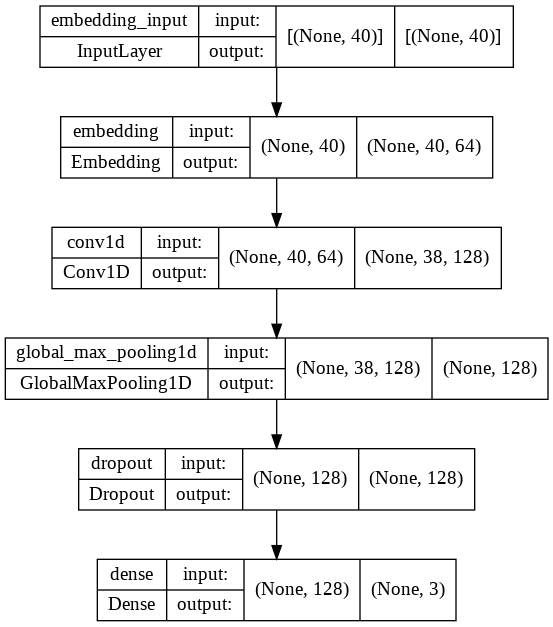

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

### Let's train the model

In [ ]:
epochs = 20

history = model.fit(train_ds.shuffle(2000).batch(16),
                    epochs = epochs ,
                    validation_data = valid_ds.batch(16),
                    verbose = 1)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1505/1505 [==============================] - 19s 5ms/step - loss: 0.9085 - categorical_accuracy: 0.6400 - val_loss: 0.8095 - val_categorical_accuracy: 0.7111
Epoch 2/20
1505/1505 [==============================] - 7s 5ms/step - loss: 0.8187 - categorical_accuracy: 0.7106 - val_loss: 0.8006 - val_categorical_accuracy: 0.7238
Epoch 3/20
1505/1505 [==============================] - 7s 5ms/step - loss: 0.8056 - categorical_accuracy: 0.7193 - val_loss: 0.8089 - val_categorical_accuracy: 0.7235
Epoch 4/20
1505/1505 [==============================] - 7s 5ms/step - loss: 0.7972 - categorical_accuracy: 0.7245 - val_loss: 0.8119 - val_categorical_accuracy: 0.7235
Epoch 5/20
1505/1505 [==============================] - 8s 5ms/step - loss: 0.7866 - categorical_accuracy: 0.7314 - val_loss: 0.8172 - val_categorical_accuracy: 0.7220
Epoch 6/20
1505/1505 [==============================] - 7s 5ms/step - loss: 0.7782 - categorical_accuracy: 0.7397 - val_loss: 0.8175 - val_categorical_accuracy: 0.7246
Ep

In [ ]:
history.history

{'categorical_accuracy': [0.6399734020233154,
  0.7105831503868103,
  0.7193470597267151,
  0.7245389819145203,
  0.7313507199287415,
  0.7397408485412598,
  0.7470510005950928,
  0.7563964128494263,
  0.7706844806671143,
  0.7808190584182739,
  0.7926150560379028,
  0.8051586747169495,
  0.8162900805473328,
  0.8263415694236755,
  0.8365176916122437,
  0.8454062342643738,
  0.849975049495697,
  0.8552085161209106,
  0.8594866394996643,
  0.8674613833427429],
 'loss': [0.908525824546814,
  0.8187459111213684,
  0.8056113123893738,
  0.7972032427787781,
  0.7865930199623108,
  0.7782435417175293,
  0.7648149132728577,
  0.753233015537262,
  0.7332790493965149,
  0.7209022045135498,
  0.7079699039459229,
  0.6919651031494141,
  0.6820877194404602,
  0.671971321105957,
  0.6630891561508179,
  0.6520891189575195,
  0.6476825475692749,
  0.6415373086929321,
  0.6361603140830994,
  0.6293745636940002],
 'val_categorical_accuracy': [0.7111360430717468,
  0.7238415479660034,
  0.72346788644790

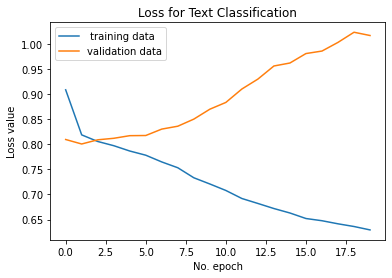

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

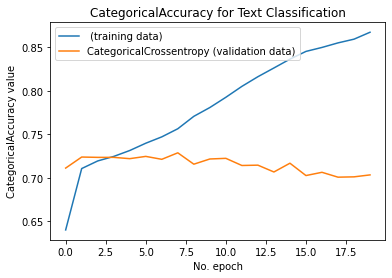

In [ ]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Save Our Model

In [ ]:
#model.save('C:\\TweetSenitment\\savedTFCNNModel\\tf_cnnmodel') 
#json_string = tokenizer.to_json()

## Save Our Tokenizer

In [ ]:
#import json
#with open('C:\\TweetSenitment\\savedTFCNNModel\\tokenizer.json', 'w') as outfile:
#    json.dump(json_string, outfile)

## Load the Model

In [ ]:
#new_model = tf.keras.models.load_model('C:\\TweetSenitment\\savedTFCNNModel\\tf_cnnmodel')
#new_model.summary()

## Load the Tokenizer

In [ ]:
#with open('C:\\TweetSenitment\\savedTFCNNModel\\tokenizer.json') as json_file:
#    json_string = json.load(json_file)
#tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

## Prediction

In [ ]:
x_test  = np.array(tokenizer.texts_to_sequences(test_data['text'].tolist()))
x_test = pad_sequences(x_test, padding='post', maxlen=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
x_test[0]

array([   68,  1077,     1,     2,    11, 17377,  1430,  4186,     1,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [ ]:
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.39372438 0.7375583  0.32439154]
 [0.06970356 0.47421548 0.91771   ]
 [0.9786926  0.72560656 0.00602955]
 ...
 [0.54523945 0.7506991  0.18955743]
 [0.01020222 0.6849809  0.9701323 ]
 [0.00947179 0.65684724 0.97457576]]


In [ ]:
print(predict_results)

[1 2 0 ... 1 2 2]


In [ ]:
predictions[1]

array([0.06970356, 0.47421548, 0.91771   ], dtype=float32)

In [ ]:
predict_results_1 = predictions[1].argmax()
predict_results_1

2

In [ ]:
predict_results.shape

(3434,)

In [ ]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

In [ ]:
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.77      0.74      0.75      1075
    negative       0.72      0.68      0.70       983
     neutral       0.66      0.70      0.68      1376

    accuracy                           0.71      3434
   macro avg       0.71      0.71      0.71      3434
weighted avg       0.71      0.71      0.71      3434

